**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

**Import Some Necassary Pakcages**

In [8]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt

import pickle
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Dropout,Activation, Flatten,Conv2D,MaxPooling2D
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

"i" is an array which will have images from all the directorires

"l" is an array which will have labels as string form (title of the folder)

**Inatialize the paths of training directory and its folders**

In [12]:
i=[]
l=[]
size=128
ate='/content/drive/MyDrive/Training/1. ATELECTASIS'
car='/content/drive/MyDrive/Training/2. CARDIOMEGALY'
con='/content/drive/MyDrive/Training/3. CONSOLIDATION'
ede='/content/drive/MyDrive/Training/4. EDEMA'
nof='/content/drive/MyDrive/Training/9. NO FINDING'
ple='/content/drive/MyDrive/Training/10. PLEURAL EFFUSION'



**Inatialize the paths of validation directory and its folders**

In [15]:
i=[]
l=[]
ate='/content/drive/MyDrive/Validation/1. ATELECTASIS'
car='/content/drive/MyDrive/Validation/2. CARDIOMEGALY'
con='/content/drive/MyDrive/Validation/3. CONSOLIDATION'
ede='/content/drive/MyDrive/Validation/4. EDEMA'
nof='/content/drive/MyDrive/Validation/9. NO FINDING'
ple='/content/drive/MyDrive/Validation/10. PLEURAL EFFUSION'

This Function will return Catagory of the image ( label of image)

In [10]:
def get_label(img,cat):
    return cat

This Function will itarate given Directory (DIR) and will read all the images resize them and will add them to the i vector.

*   As For labels it will be passed on while calling the function and for every image read the label will be added to l vector.



---


*   **While doing this porject I noticed that the Data for EDEMA is not sufficent and Data for PLEURAL EFFUSION is not enough. so I did data augmentation on these two folder which signaficantly improved my results**


---

In [11]:
def make_data_set(cat, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = get_label(img, cat)
        img_path = os.path.join(DIR, img)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size))
        i.append(np.array(img))
        l.append(str(label))
        if cat=="EDEMA" or cat=="PLEURAL EFFUSION":
                img = cv2.flip(img, 0)
                i.append(np.array(img))
                l.append(str(label))
                img = cv2.flip(img, 1)
                i.append(np.array(img))
                l.append(str(label))
                      

Calling the function one by one for each label/catagory


*   Final label matrix will have string label equal to number of images in "i"
*   Change that label matrix in to one-hot codding form by calling in built function
*   Normalize the image array
*   Now shuffle the data (labels as well as images) to make data more random

In [16]:
make_data_set('ATELECTASIS',ate)
make_data_set('CARDIOMEGALY',car)
make_data_set('CONSOLIDATION',con)
make_data_set('EDEMA',ede)
make_data_set('NO FINDING',nof)
make_data_set('PLEURAL EFFUSION',ple)
le=LabelEncoder()
L=le.fit_transform(l)
L=to_categorical(L,6)
I=np.array(i)
I=I/255
I=tf.random.shuffle(I,123)
L=tf.random.shuffle(L,123)

100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


Below two Sections will save npy arrays

In [14]:
np.save('train_x',I)
np.save('train_y',L)

In [17]:
np.save('valid_x',I)
np.save('valid_y',L)

Read NP array as images and labels

In [18]:
train_images=np.load('/content/train_x.npy')
train_labels=np.load('/content/train_y.npy')
valid_images=np.load('/content/valid_x.npy')
valid_labels=np.load('/content/valid_y.npy')

In [19]:
print(train_images.shape,train_labels.shape)
print(valid_images.shape,valid_labels.shape)

(2086, 128, 128, 3) (2086, 6)
(710, 128, 128, 3) (710, 6)


In [26]:
activation="tanh"
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation=activation,kernel_regularizer='l2', padding = 'same', input_shape=(size,size,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(units=128, activation=activation,name='d1', dtype='float32'),    
    Dense(units=64, activation=activation,name='d2', dtype='float32'),
    Dense(units=16, activation=activation,name='d3', dtype='float32'),
    Dense(units=32, activation='relu',name='d4', dtype='float32'),
    Dense(units=6, activation='softmax',name='Output', dtype='float32')
])

In [29]:
# Adam,SGD,RMSprop,Adagrad
my_optimiser = SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=my_optimiser, metrics=['categorical_accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

While training the model suffling helped to improve accuracy

In [28]:
model.fit(train_images, train_labels,batch_size=10, epochs=50,validation_data=(valid_images,valid_labels),validation_batch_size=5,shuffle=True)

Epoch 1/50
209/209 [==============================] - 4s 15ms/step - loss: 1.3961 - categorical_accuracy: 0.4477 - val_loss: 1.4524 - val_categorical_accuracy: 0.4282
Epoch 2/50
209/209 [==============================] - 3s 12ms/step - loss: 1.2716 - categorical_accuracy: 0.4976 - val_loss: 1.2362 - val_categorical_accuracy: 0.5099
Epoch 3/50
209/209 [==============================] - 3s 14ms/step - loss: 1.2145 - categorical_accuracy: 0.5201 - val_loss: 1.2023 - val_categorical_accuracy: 0.5155
Epoch 4/50
209/209 [==============================] - 3s 12ms/step - loss: 1.1823 - categorical_accuracy: 0.5412 - val_loss: 1.2181 - val_categorical_accuracy: 0.5254
Epoch 5/50
209/209 [==============================] - 3s 13ms/step - loss: 1.1566 - categorical_accuracy: 0.5499 - val_loss: 1.1212 - val_categorical_accuracy: 0.5507
Epoch 6/50
209/209 [==============================] - 3s 13ms/step - loss: 1.1371 - categorical_accuracy: 0.5551 - val_loss: 1.1664 - val_categorical_accuracy: 0.532

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [24]:
my_predictions = model.predict(valid_images)

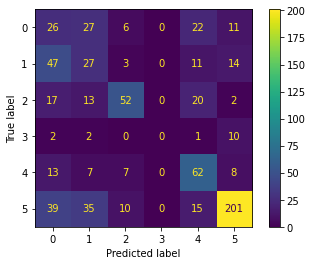

In [25]:
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(valid_labels, axis=1)), list(np.argmax(my_predictions, axis=1)))))
cmd.plot()
plt.show()